In [1]:
import numpy as np
from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction
from pydrake.all import StartMeshcat, BasicVector, LogVectorOutput
import matplotlib.pyplot as plt, datetime
import pydot

In [2]:
from preflight import dircol
from flight import flight
from landing import landing
from phase_switch import PhaseSwitch
from osc_modified import OperationalSpaceWalkingController

# System Setup

DIRCOL Gives COM trajectory. OSC takes Desired trajectory and tracks it.  

In [3]:
#Start the meshcat server
meshcat = StartMeshcat(); builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
parser = Parser(plant)
parser.AddModels("../models/planar_walker.urdf")
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()


#### Designing the controller ####
postlandingCOM = 1 #desired Z height in meters
base_traj_src = builder.AddSystem(ConstantVectorSource(np.array([0])))
post_flight_traj_src = builder.AddSystem(ConstantVectorSource(np.array([0,0,0.8]))) 

landing_planner = builder.AddSystem(landing())
osc = builder.AddSystem(OperationalSpaceWalkingController())

## Logger ##
logger = LogVectorOutput(osc.GetOutputPort("metrics"),builder)

#### Wiring ####

#Landing wiring
builder.Connect(plant.get_state_output_port(), landing_planner.get_state_input_port())
builder.Connect(base_traj_src.get_output_port(), landing_planner.get_torso_input_port())
builder.Connect(post_flight_traj_src.get_output_port(), landing_planner.get_com_input_port())


#DIRCOL OUT -> OSC IN
builder.Connect(landing_planner.get_com_output_port(), osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), osc.get_traj_input_port("base_joint_traj")) #Dummy port for now
builder.Connect(plant.get_state_output_port(), osc.get_state_input_port()) 
builder.Connect(osc.torque_output_port, plant.get_actuation_input_port())

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.0005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

#simulate
diagram = builder.Build()
graph = (pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg())

with open('graph.svg', 'wb') as f:
    f.write(graph)

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Simulation Setup


-0.01


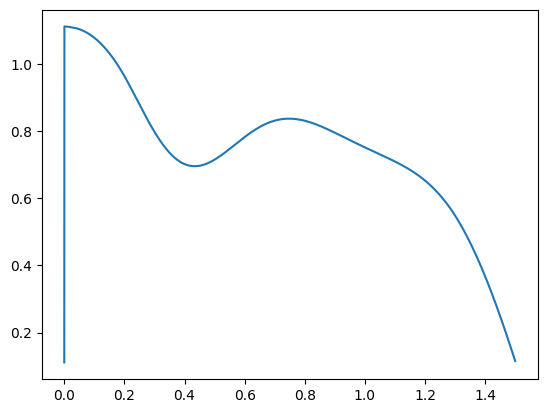

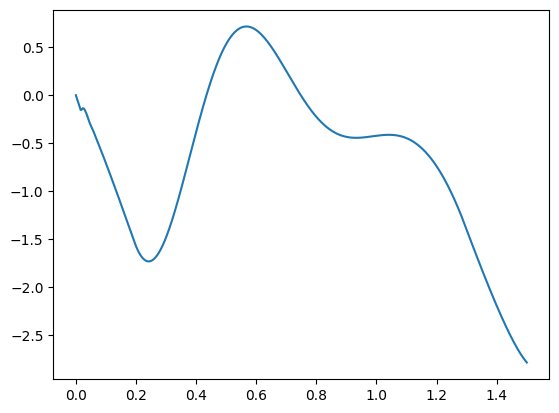

In [4]:
sim_time = 1.5
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(1)

# State Description: q = [x, z, planar_roty, left_hip, left_knee, right_hip, right_knee]
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())

q = np.zeros((plant.num_positions(),))
q[0] = 0; q[1] = 1.0
theta = -np.arccos(q[1])
print(theta)
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
plant.SetPositions(plant_context, q)

# Simulate the robot
simulator.AdvanceTo(sim_time)

## Logs and Plots ##
log = logger.FindLog(simulator.get_mutable_context()) #xyz vxvyvz
t = log.sample_times()
x = log.data()[2]   
xdot = log.data()[-1]

plt.figure()
plt.plot(t, x)
plt.figure()
plt.plot(t, xdot)
# plt.savefig(f"./logs/{time}plots.png")
plt.show()